这个Notebook是[The Annotated Transformer](https://nlp.seas.harvard.edu/annotated-transformer/)和cs231n的学习笔记.

![alt text](resources/transformer_arch.png "Title")

###  多头注意力机制实现
下面这段介绍是从cs231n作业上抄下来的多头注意力机制详细的描述
#### Dot-Product Attention

Recall that attention can be viewed as an operation on a query $q\in\mathbb{R}^d$, a set of value vectors $\{v_1,\dots,v_n\}, v_i\in\mathbb{R}^d$, and a set of key vectors $\{k_1,\dots,k_n\}, k_i \in \mathbb{R}^d$, specified as

\begin{align}
c = \sum_{i=1}^{n} v_i \alpha_i, &\ \ \ \alpha_i = \frac{\exp(k_i^\top q)}{\sum_{j=1}^{n} \exp(k_j^\top q)} \\
\end{align}

where $\alpha_i$ are frequently called the "attention weights", and the output $c\in\mathbb{R}^d$ is a correspondingly weighted average over the value vectors.

#### Self-Attention
In Transformers, we perform self-attention, which means that the values, keys and query are derived from the input $X \in \mathbb{R}^{\ell \times d}$, where $\ell$ is our sequence length. Specifically, we learn parameter matrices $V,K,Q \in \mathbb{R}^{d\times d}$ to map our input $X$ as follows:

\begin{align}
v_i = Vx_i\ \ i \in \{1,\dots,\ell\}\\
k_i = Kx_i\ \ i \in \{1,\dots,\ell\}\\
q_i = Qx_i\ \ i \in \{1,\dots,\ell\}
\end{align}

#### Multi-Headed Scaled Dot-Product Attention
In the case of multi-headed attention, we learn a parameter matrix for each head, which gives the model more expressivity to attend to different parts of the input. Let $h$ be number of heads, and $Y_i$ be the attention output of head $i$. Thus we learn individual matrices $Q_i$, $K_i$ and $V_i$. To keep our overall computation the same as the single-headed case, we choose $Q_i \in \mathbb{R}^{d\times d/h}$, $K_i \in \mathbb{R}^{d\times d/h}$ and $V_i \in \mathbb{R}^{d\times d/h}$. Adding in a scaling term $\frac{1}{\sqrt{d/h}}$ to our simple dot-product attention above, we have

\begin{equation}
Y_i = \text{softmax}\bigg(\frac{(XQ_i)(XK_i)^\top}{\sqrt{d/h}}\bigg)(XV_i)
\end{equation}

where $Y_i\in\mathbb{R}^{\ell \times d/h}$, where $\ell$ is our sequence length.

In our implementation, we apply dropout to the attention weights (though in practice it could be used at any step):

\begin{equation}
Y_i = \text{dropout}\bigg(\text{softmax}\bigg(\frac{(XQ_i)(XK_i)^\top}{\sqrt{d/h}}\bigg)\bigg)(XV_i)
\end{equation}

Finally, then the output of the self-attention is a linear transformation of the concatenation of the heads:

\begin{equation}
Y = [Y_1;\dots;Y_h]A
\end{equation}

were $A \in\mathbb{R}^{d\times d}$ and $[Y_1;\dots;Y_h]\in\mathbb{R}^{\ell \times d}$.

多头注意力机制的计算流程图

![alt text](resources/multiheadattention.png "Title")

In [1]:
import torch
import torch.nn as nn
import math
from torch import Tensor
from typing import Optional


class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, dropout: float = 0.1) -> None:
        """简单的多头注意力实现,主要来自我的cs231n的作业.

        Args:
            embed_dim: Dimension of the token embedding.
            num_heads: Number of attention heads.
            dropout: Dropout probability. Defaults to 0.1.
        """
        super().__init__()
        assert embed_dim % num_heads == 0

        self.n_heads = num_heads
        self.embed_dim = embed_dim
        self.head_dim = embed_dim // num_heads

        self.key_project = nn.Linear(embed_dim, embed_dim)
        self.query_project = nn.Linear(embed_dim, embed_dim)
        self.value_project = nn.Linear(embed_dim, embed_dim)
        self.output_project = nn.Linear(embed_dim, embed_dim)
        self.drop = nn.Dropout(dropout)

    def forward(
        self,
        query: Tensor,
        key: Tensor,
        value: Tensor,
        atten_mask: Optional[Tensor] = None,
    ) -> Tensor:
        """
        Calculate the masked attention output for the provided data, computing
        all attention heads in parallel.

        In the shape definitions below, N is the batch size, S is the source
        sequence length, T is the target sequence length, and E is the embedding
        dimension.

        Args:
            query: Input data to be used as the query, of shape (N, S, E)
            key: Input data to be used as the key, of shape (N, T, E)
            value: Input data to be used as the value, of shape (N, T, E)
            atten_mask: Array of shape (S, T) where mask[i,j] == 0 indicates token
                        i in the source should not influence token j in the target.

        Returns:
            output: Tensor of shape (N, S, E) giving the weighted combination of
                    data in value according to the attention weights calculated using key
                    and query.
        """
        N, S, E = query.shape
        N, T, E = value.shape
        # Perform input projection
        query = (
            self.query_project(query)
            .contiguous()
            .view(N, S, self.n_heads, self.head_dim)
        )
        key = self.key_project(key).contiguous().view(N, T, self.n_heads, self.head_dim)
        value = (
            self.value_project(value)
            .contiguous()
            .view(N, T, self.n_heads, self.head_dim)
        )

        # 将注意力的维度挪到batch维度之后
        query = query.transpose(1, 2)  # shape (N,H,S,HD)
        key = key.transpose(1, 2)  # shape (N,H,T,HD)
        value = value.transpose(1, 2)  # shape (N,H,T,HD)

        # compute dot product between query and key
        # query shape (N,H,S,HD)
        # key shape (N,H,T,HD)
        # to do matmul, we should transpose key to (N,H,HD,T)
        logits = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(
            self.head_dim
        )  # shape (N,H,S,T)
        if atten_mask is not None:
            # 将需要屏蔽的位置替换为非常小的数值
            logits.masked_fill_(atten_mask == 0.0, -1e9)
        atten_weight = self.drop(logits.softmax(-1))  # shape (N,H,S,T)

        Y = torch.matmul(atten_weight, value)  # shape (N,H,S,HD)
        Y = Y.transpose(1, 2)  # shape (N,S,H,HD)
        Y = Y.contiguous().view(N, S, E)  # shape (N,S,E)
        return self.output_project(Y)

### Positional Encoding

While transformers are able to easily attend to any part of their input, the attention mechanism has no concept of token order. However, for many tasks (especially natural language processing), relative token order is very important. To recover this, the authors add a positional encoding to the embeddings of individual word tokens.

Let us define a matrix $P \in \mathbb{R}^{l\times d}$, where $P_{ij} = $

$$
\begin{cases}
\text{sin}\left(i \cdot 10000^{-\frac{j}{d}}\right) & \text{if j is even} \\
\text{cos}\left(i \cdot 10000^{-\frac{(j-1)}{d}}\right) & \text{otherwise} \\
\end{cases}
$$

Rather than directly passing an input $X \in \mathbb{R}^{l\times d}$ to our network, we instead pass $X + P$.

In [2]:
class PositionalEncoding(nn.Module):
    """
    Encodes information about the positions of the tokens in the sequence. In
    this case, the layer has no learnable parameters, since it is a simple
    function of sines and cosines.
    """

    def __init__(
        self, embed_dim: int, dropout: float = 0.1, max_len: int = 5000
    ) -> None:
        """
        Construct the PositionalEncoding layer.

        Inputs:
         - embed_dim: the size of the embed dimension
         - dropout: the dropout value
         - max_len: the maximum possible length of the incoming sequence
        """
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, embed_dim, 2) * -(math.log(10000.0) / embed_dim)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Element-wise add positional embeddings to the input sequence.

        Inputs:
            x: the sequence fed to the positional encoder model, of shape
               (N, S, D), where N is the batch size, S is the sequence length and
                D is embed dim.
        Returns:
            output: the input sequence + positional encodings, of shape (N, S, D).
        """
        N, S, D = x.shape
        output = self.dropout(self.pe[:, :S, :] + x)
        return output


def subsequent_mask(size: int):
    """Mask out subsequent positions."""
    attn_shape = (1, size, size)
    subsequent_mask = torch.triu(torch.ones(attn_shape), diagonal=1).type(torch.uint8)
    return subsequent_mask == 0

可视化Positional Embedding

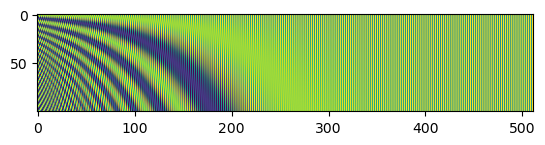

In [3]:
import matplotlib.pyplot as plt

PE = PositionalEncoding(512, 0.1)
plt.imshow(PE.pe.squeeze()[:100, :].numpy())

### Position-wise Feedforward Network
![alt text](resources/positionwise_mlp.png "Title")

In [4]:
class PositionWiseMLP(nn.Sequential):
    def __init__(self, embed_dim: int, diff_dim: int, dropout: float) -> None:
        layers = [
            nn.Linear(embed_dim, diff_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(diff_dim, embed_dim),
        ]
        super().__init__(*layers)

### Sublayer架构

#### Transformer中Post-Norm与Pre-Norm的对比分析

在Transformer架构中，**Post-Norm**（后归一化）和**Pre-Norm**（前归一化）是层归一化（Layer Normalization）相对于残差连接的两种不同放置策略，显著影响模型训练和性能。

##### 1. Post-Norm（原始Transformer设计）
**结构公式**：`Output = LN(x + Sublayer(x))`  

###### ✅ 优点
- **输出稳定**：每层输出强制归一化，缓解内部协变量偏移
- **理论一致性**：符合原始Transformer论文设计（Vaswani et al., 2017）

###### ❌ 缺点
- **训练不稳定**：深层模型易出现梯度消失/爆炸
- **依赖Warm-up**：需配合学习率预热策略
- **收敛速度慢**：通常需要更多训练步数

##### 2. Pre-Norm（现代主流设计）
**结构公式**：`Output = x + Sublayer(LN(x))`  
###### ✅ 优点
- **训练稳定**：梯度可通过恒等映射直接回传（缓解梯度消失）
- **收敛速度快**：通常减少30-50%训练步数
- **无需Warm-up**：降低优化策略复杂度
- **支持深层模型**：百层以上Transformer的可行方案

###### ❌ 缺点
- **输出范围变化**：激活值随网络深度递增
- **理论性能上限**：可能略低于Post-Norm（实际少见）

##### 3. 关键特性对比
| 特性                | Post-Norm                  | Pre-Norm                   |
|---------------------|----------------------------|----------------------------|
| **训练稳定性**      | 差（深层梯度问题严重）     | 优（梯度有"捷径"）         |
| **收敛速度**        | 慢                         | 快                         |
| **Warm-up依赖**     | 强依赖                     | 基本不需要                 |
| **输出分布**        | 每层严格归一化             | 随深度递增                 |
| **千层模型支持**    | 不可行                     | 可行                       |
| **代表模型**        | 原始Transformer            | GPT系列、BERT、LLaMA、T5等 |

##### 4. 实际应用建议
- **深层模型（≥12层）**：优先使用Pre-Norm（现代大模型标配）
- **浅层模型（<12层）**：两者均可尝试，Post-Norm可能有轻微优势
- **百亿参数级模型**：推荐Pre-Norm变体（如DeepNorm）

In [5]:
class SublayerConnection(nn.Module):
    def __init__(self, embed_dim: int, dropout: float, post_norm: bool = False) -> None:
        """Sublayer module.

        Args:
            embed_dim: Input feature size.
            dropout: dropout ratio.
            post_norm: Whether to use post-norm or pre-norm architecture.
                       关于
                       see: https://zhuanlan.zhihu.com/p/480783670
                            https://arxiv.org/pdf/2002.04745
        """
        super().__init__()
        self.ln = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)
        self.post_norm = post_norm

    def forward(self, x: Tensor, sublayer: nn.Module) -> Tensor:
        if self.post_norm:
            return self.ln(x + self.dropout(sublayer(x)))
        else:
            return x + self.dropout(sublayer(self.ln(x)))

### Encoder

In [6]:
import copy

from torch.nn import ModuleList


def clones(module, N) -> ModuleList:
    """Produce N identical layers."""
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


class EncoderLayer(nn.Module):
    def __init__(
        self, embed_dim: int, n_heads: int, diff_dim: int, dropout: float
    ) -> None:
        super().__init__()
        # self attention
        self.self_atten = MultiHeadAttention(embed_dim, n_heads, dropout)
        self.sublayer_1 = SublayerConnection(embed_dim, dropout)
        self.mlp = PositionWiseMLP(embed_dim, diff_dim, dropout)
        self.sublayer_2 = SublayerConnection(embed_dim, dropout)

    def forward(self, x: Tensor):
        x = self.sublayer_1(x, lambda x: self.self_atten(x, x, x))
        x = self.sublayer_2(x, self.mlp)
        return x


class Encoder(nn.Sequential):
    def __init__(
        self,
        embed_dim: int,
        n_heads: int,
        diff_dim: int,
        dropout: float,
        num_layers: int,
    ) -> None:
        layers = [
            EncoderLayer(embed_dim, n_heads, diff_dim, dropout)
            for _ in range(num_layers)
        ]
        super().__init__(*layers)

In [7]:
encoder = Encoder(
    embed_dim=55,
    n_heads=5,
    diff_dim=77,
    dropout=0,
    num_layers=2,
)
result = encoder(torch.ones(10, 12, 55))
assert result.shape == (10, 12, 55)
assert torch.all(result[0] - result[9]) < 1e-6
assert torch.all(result[0][0] - result[0][1]) < 1e-6

### Decoder

In [8]:
class DecoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"

    def __init__(
        self, embed_dim: int, n_heads: int, diff_dim: int, dropout: float
    ) -> None:
        super().__init__()
        # self attention
        self.self_atten = MultiHeadAttention(embed_dim, n_heads, dropout)
        self.sublayer_1 = SublayerConnection(embed_dim, dropout)
        # source attention
        self.src_atten = MultiHeadAttention(embed_dim, n_heads, dropout)
        self.sublayer_2 = SublayerConnection(embed_dim, dropout)
        self.mlp = PositionWiseMLP(embed_dim, diff_dim, dropout)
        self.sublayer_3 = SublayerConnection(embed_dim, dropout)

    def forward(self, x: Tensor, memory: Tensor, mask: Tensor) -> Tensor:
        """_summary_

        Args:
            x: Decoder sequence of shape (N,T,E)
            memory: Encoder sequence of shape (N,S,E)
            mask: Decoder sequence mask

        Returns:
            _description_
        """
        x = self.sublayer_1(x, lambda x: self.self_atten(x, x, x, mask))
        x = self.sublayer_3(x, lambda x: self.src_atten(x, memory, memory))
        x = self.sublayer_3(x, self.mlp)
        return x


class Decoder(nn.Module):
    def __init__(
        self,
        embed_dim: int,
        n_heads: int,
        diff_dim: int,
        dropout: float,
        num_layers: int,
    ) -> None:
        super().__init__()
        self.layers = nn.ModuleList(
            [
                DecoderLayer(embed_dim, n_heads, diff_dim, dropout)
                for _ in range(num_layers)
            ]
        )

    def forward(self, x: Tensor, memory: Tensor, mask: Tensor) -> Tensor:
        for layer in self.layers:
            x = layer(x, memory, mask)
        return x

### Embedding Layer

In [9]:
class Embeddings(nn.Module):
    def __init__(self, embed_dim: int, vocab_size: int) -> None:
        super().__init__()
        self.lut = nn.Embedding(vocab_size, embed_dim)
        self.embed_dim = embed_dim

    def forward(self, x: Tensor) -> Tensor:
        return self.lut(x) * math.sqrt(self.embed_dim)

### Transformer Model

In [10]:
from turtle import position
from altair import Position
from torch._tensor import Tensor


class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many
    other models.
    """

    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def forward(self, src, tgt, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src), tgt, tgt_mask)

    def encode(self, src):
        return self.encoder(self.src_embed(src))

    def decode(self, memory, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, tgt_mask)


class Generator(nn.Module):
    "Define standard linear + softmax generation step."

    def __init__(self, embed_dim, vocab_size) -> None:
        super(Generator, self).__init__()
        self.proj = nn.Linear(embed_dim, vocab_size)

    def forward(self, x: Tensor) -> Tensor:
        return nn.functional.log_softmax(self.proj(x), dim=-1)


def make_model(
    src_vocab_size: int,
    tgt_vocab_size: int,
    num_layers: int = 6,
    embed_dim: int = 512,
    diff_dim: int = 2048,
    n_heads=8,
    dropout=0.1,
) -> EncoderDecoder:
    encoder = Encoder(embed_dim, n_heads, diff_dim, dropout, num_layers)
    decoder = Decoder(embed_dim, n_heads, diff_dim, dropout, num_layers)
    position_encoding = PositionalEncoding(embed_dim, dropout)
    model = EncoderDecoder(
        encoder,
        decoder,
        nn.Sequential(Embeddings(embed_dim, src_vocab_size), position_encoding),
        nn.Sequential(Embeddings(embed_dim, tgt_vocab_size), position_encoding),
        Generator(embed_dim, tgt_vocab_size),
    )
    # This was important from their code.
    # Initialize parameters with Glorot / fan_avg.
    # 这个初始化方法会让ViT不稳定,建议乘以0.1
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

# Run inference test

In [11]:
def inference_test():
    test_model = make_model(11, 100, 2)
    test_model.eval()
    src = torch.LongTensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])

    memory = test_model.encode(src)
    ys = torch.zeros(1, 1).type_as(src)

    for i in range(15):
        out = test_model.decode(
            memory, ys, subsequent_mask(ys.size(1)).type_as(src.data)
        )
        prob = test_model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]
        ys = torch.cat(
            [ys, torch.empty(1, 1).type_as(src.data).fill_(next_word)], dim=1
        )

    print("Example Untrained Model Prediction:", ys)


def run_tests():
    for _ in range(10):
        inference_test()


run_tests()

Example Untrained Model Prediction: tensor([[ 0, 15, 15, 15, 15, 70, 15, 70, 15, 18, 70, 70, 70, 70, 70, 70]])
Example Untrained Model Prediction: tensor([[ 0, 78, 70, 78, 70, 78, 70, 78, 70, 78, 70, 78, 70, 78, 70, 78]])
Example Untrained Model Prediction: tensor([[ 0,  1, 18, 48, 46, 63, 64, 43, 66, 66, 66, 95, 18, 48, 66, 18]])
Example Untrained Model Prediction: tensor([[ 0, 38, 38, 38, 38, 38, 38, 33, 27, 51, 27, 27, 51, 51, 51, 51]])
Example Untrained Model Prediction: tensor([[ 0, 82, 39, 26, 74, 82, 39, 26, 67, 74, 82, 39, 57, 56,  4, 87]])
Example Untrained Model Prediction: tensor([[ 0, 94, 90, 54, 90,  4, 90,  4, 90,  4, 90,  4, 90,  4,  4,  4]])
Example Untrained Model Prediction: tensor([[ 0, 94,  3, 42, 58, 58, 58, 58, 53, 66, 91, 60,  3, 42, 58, 21]])
Example Untrained Model Prediction: tensor([[ 0, 95,  0, 58, 70, 58, 70, 58, 70, 58, 67, 36,  1, 58, 78, 36]])
Example Untrained Model Prediction: tensor([[ 0, 89, 48, 93, 66, 90, 21, 72, 72, 72, 72, 72, 72, 72, 72, 72]])
E